# Multilayer Perception

In this tutorial, we will cover:

* N-layer MLP with PyTorch's `nn.Module`, `nn.NNLoss` and `optim` modules
* A simpler approach with scikit learn tools

In [23]:
# Setup
%matplotlib inline
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Sequence

# plt.rcParams['font.size'] = 20

# Some Theory

The following hypothesis class
$$
\mathcal{H} =
\left\{ h: \mathcal{X}\rightarrow\mathcal{Y}
~\vert~
h(\vec{x}) = \varphi(\vec{w}^T\vec{x}+b); \vec{w}\in\set{R}^D,~b\in\set{R}\right\}
$$
where $\varphi(\cdot)$ is some nonlinear function, is composed of functions representing the **perceptron** model.


<img src="perceptron.png" width=400 /> 

# The Dataset we'll be working with: the MNIST hand written digits

In [2]:
import torchvision
from torchvision import datasets, transforms

In [3]:
# Define a transform to normalize the data
# -0.5 to +0.5 are converted to values from 0 to 1

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [4]:
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [5]:
dataiter = iter(trainloader)

images, labels = dataiter.next()

torch.Size([64, 1, 28, 28])
torch.Size([64])


Label = 9




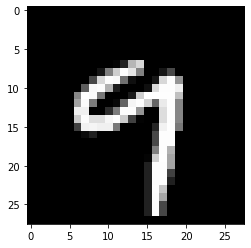

In [6]:
print(images.shape)
print(labels.shape)
plt.imshow(images[17].numpy().squeeze(), cmap='Greys_r');

print(f'\n\nLabel = {labels[17]}\n\n')

In [7]:
trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
n_features = torch.numel(images[17])
n_classes = 10

In [10]:
n_features  # 28 x 28 (pixels that are inputs to a perceptron)

784

# N-Layer MLP using PyTorch

* Dataset
* Model
* Loss function
* Optimizer

## Dataset

### Load the MNIST dataset "lazily" with batches and a "smart" DataLoader

In [11]:
BATCH_SIZE = 512
TRAIN_SIZE = BATCH_SIZE * 10
TEST_SIZE  = BATCH_SIZE * 2

In [12]:
# Datasets and loaders
train_set    = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           sampler=torch.utils.data.SubsetRandomSampler(range(TRAIN_SIZE)))
             

In [13]:
            
test_set    = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)


test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                          sampler=torch.utils.data.SubsetRandomSampler(range(TEST_SIZE)))

## Multilayer Perceptron (MLP)

### Model

<center><img src="mlp.png" width=1000 /></center>





Composed of $L$ **layers**, each layer $l$ with $n_l$ **perceptron** ("neuron") units.

$$\hat{y} = \varphi(\vec{w}^T \psi(\vec{x})+b).$$



Each layer $l$ operates on the output of the previous layer

Given an input sample $\vec{x}^i$, the computed function of an $L$-layer MLP is:
$$
\hat{\vec{y}_L^i}= \varphi \left(
\mat{W}_L \varphi \left( \cdots
\varphi \left( \mat{W}_1 \vec{x}^i + \vec{b}_1 \right)
\cdots \right)
+ \vec{b}_L \right)
$$

# Model Implementation

In [14]:
import torch.nn as nn
from typing import Sequence

### Let's inherit pytorch's MLP class and modify it to our characteristics

In [15]:
class MLP(torch.nn.Module):
    
    def __init__(self, D_in: int, hidden_dims: Sequence[int], D_out: int):
        super().__init__()
        
        all_dims = [D_in, *hidden_dims, D_out]
        non_linearity = torch.nn.ReLU
        layers = []
        
        
        # build the layers
        for in_dim, out_dim in zip(all_dims[:-1], all_dims[1:]):
            layers += [
                nn.Linear(in_dim, out_dim, bias=True),
                non_linearity()
            ]
        
        # Sequential is a container for layers
        self.fc_layers = nn.Sequential(*layers[:-1])
        
        
        # Output non-linearity
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], -1))
        z = self.fc_layers(x)
        y_pred = self.log_softmax(z)
        return y_pred                  # Output is always log-probability

## Example:
## Create an architecture with: 2-layer MLP (1 hidden layer with 50 percptrons)

In [16]:

mlp2 = MLP(D_in=n_features, hidden_dims=[50], D_out=n_classes)   #  D_in = 784, D_out = 10

print(mlp2)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)


## Example:
## Create an architecture model with: 5-layer MLP
### (4 hidden layers with 32, 64, 128, 64 perceptrons in each respectively)

In [440]:
# Create an instance of the model: 5-layer MLP
mlp5 = MLP(D_in=n_features, hidden_dims=[32, 64, 128, 64], D_out=n_classes)

print(mlp5)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)


In [17]:
model = mlp2#mlp5

## Loss and Optimizer

### For the loss function, we'll use PyTorch's built in negative log-likelihood loss since our model outputs probabilities.

- The `forward()` function performs the actual calculation/operation of the block and returns an output.
- The `backward()` function computes the gradient of the **input and parameters** as a function of the gradient of the **output**, according to the chain rule.

<img src="backprop.png" width="900" />

- MSE loss with L2 regularization:
    $$
    \begin{align}
    \ell(\vec{y},\vec{\hat y}) &= \frac{1}{2} \norm{\vec{\hat y} - \vec{y}}^2 \\
    L_{\mathcal{S}} &= \frac{1}{N}\sum_{i=1}^{N}\ell(\vec{y},\vec{\hat y}) + \frac{\lambda}{2}\left(\norm{\mat{W}_1}_F^2 + \norm{\mat{W}_2}_F^2 \right)
    \end{align}
    $$


In [18]:
import torch.optim

# Loss:
# Note: NLLLoss assumes *log*-probabilities (given by our LogSoftmax layer)
loss_fn = nn.NLLLoss()

# Optimizer over our model's parameters
optimizer = torch.optim.SGD(params=model.parameters(), lr=5e-2, weight_decay=0.01, momentum=0.9)

<img src="sgd.png" width="900" />

In [19]:
def plot_weights(model: MLP):
    '''
    Plots some weights matrices of the first layer
    '''
    fig, axes = plt.subplots(3,3)
    weights = list(model.fc_layers[0].parameters())[0]  # only weights of first layer
    
    for w, ax in zip(weights, axes.ravel()):
        ax.imshow(w.detach().numpy().reshape(28, 28));

        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

## Training

Epoch #1: Avg. loss=1.925678014755249


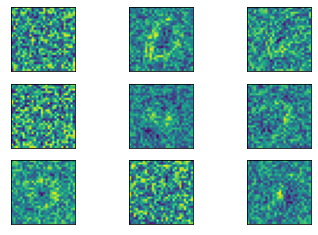

Epoch #2: Avg. loss=0.8249608755111695


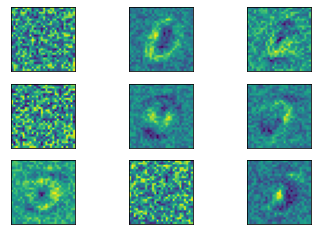

Epoch #3: Avg. loss=0.4776351660490036


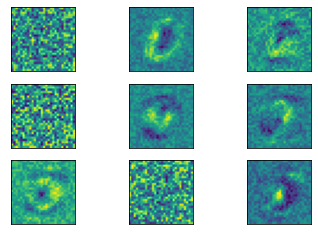

Epoch #4: Avg. loss=0.37954667806625364


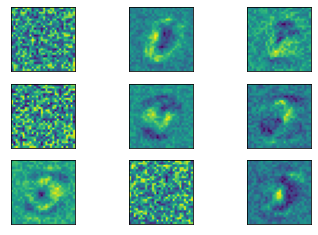

Epoch #5: Avg. loss=0.33142696917057035


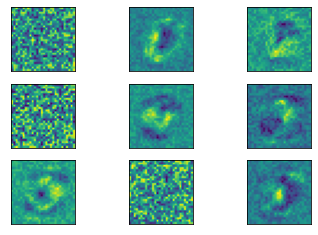

Epoch #6: Avg. loss=0.3143610119819641


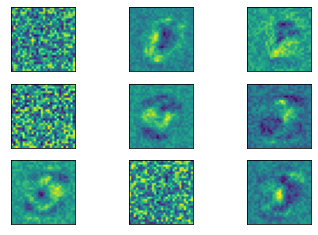

Epoch #7: Avg. loss=0.28289015889167785


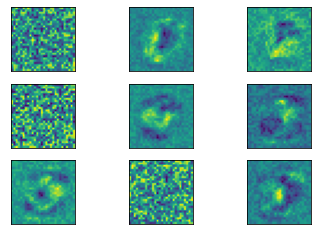

Epoch #8: Avg. loss=0.2609595224261284


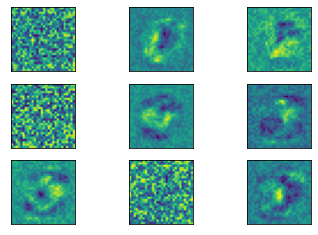

Epoch #9: Avg. loss=0.26358234137296677


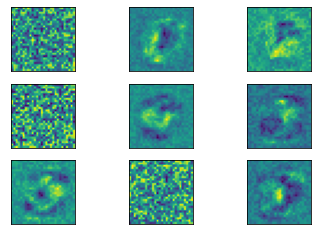

Epoch #10: Avg. loss=0.25631914734840394


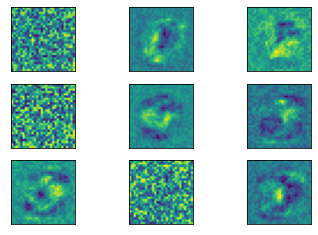

Epoch #11: Avg. loss=0.2564927786588669


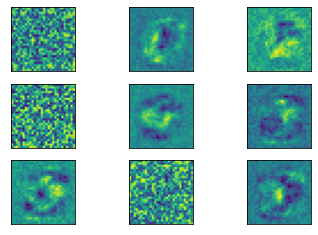

Epoch #12: Avg. loss=0.2549270331859589


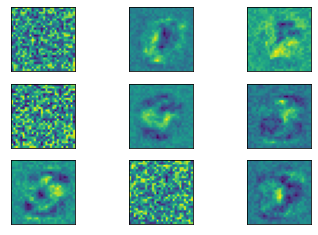

Epoch #13: Avg. loss=0.23699152767658233


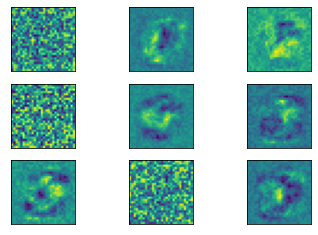

Epoch #14: Avg. loss=0.22851159572601318


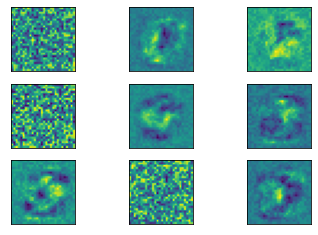

Epoch #15: Avg. loss=0.22611348927021027


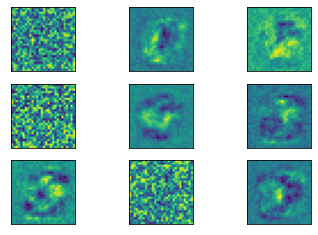

Epoch #16: Avg. loss=0.2238947257399559


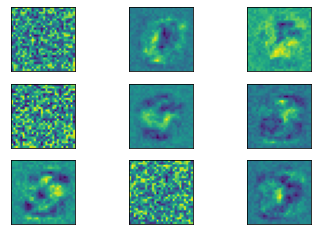

Epoch #17: Avg. loss=0.22689544409513474


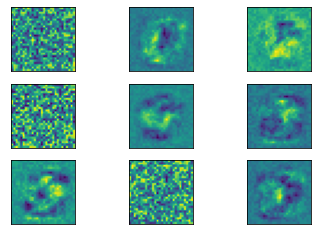

Epoch #18: Avg. loss=0.22128741890192033


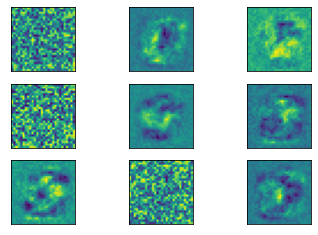

Epoch #19: Avg. loss=0.20172996819019318


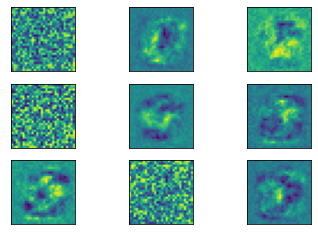

Epoch #20: Avg. loss=0.20076036155223848


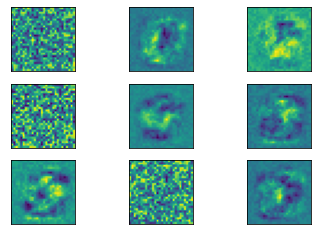

In [20]:
num_epochs = 20


for epoch_idx in range(num_epochs):
    total_loss = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        # Forward pass
        y_pred = model(X)      
        
        # Compute loss
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()   # Zero gradients of all parameters
        loss.backward()         # Run backprop algorithms to calculate gradients
        
        # Optimization step
        optimizer.step()        # Use gradients to update model parameters
        
    
    print(f'Epoch #{epoch_idx + 1}: Avg. loss={total_loss / len(train_loader)}')
    plot_weights(model)

## Calculate precision score  of our network

In [21]:
correct = 0


for batch in test_loader:
    
    #  images, true labels
    for image, label in zip(batch[0], batch[1]):
        y_pred = model(image)
        
        if torch.topk(y_pred, 10).indices[0].numpy()[0] == label:
            correct += 1

In [22]:
print(f'Prediction Precision: {correct} / {TEST_SIZE}. ({correct / TEST_SIZE})')

Prediction Precision: 914 / 1024. (0.892578125)


# Sci-Kit Learn Approach

In [449]:
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [450]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0

# Split data into train partition and test partition
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.7)

In [454]:
# create a similar network architecture as we did with pytorch
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 64, 128, 64),
    max_iter=10,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.2,
)

In [455]:
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.45821554
Iteration 2, loss = 0.45886510
Iteration 3, loss = 0.33400690
Iteration 4, loss = 0.28038989
Iteration 5, loss = 0.25035758
Iteration 6, loss = 0.23560511
Iteration 7, loss = 0.21840949
Iteration 8, loss = 0.20850437
Iteration 9, loss = 0.19261652
Iteration 10, loss = 0.19492898


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64), learning_rate_init=0.2,
              max_iter=10, random_state=1, solver='sgd', verbose=10)

In [456]:


print(f'Training set score: {mlp.score(X_train, y_train)}')
print(f'Test set score:     {mlp.score(X_test, y_test)}')



Training set score: 0.9501428571428572
Test set score:     0.9230204081632654


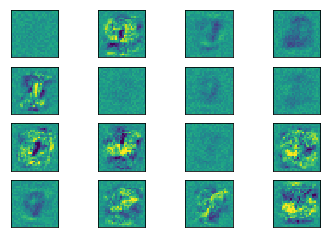

In [458]:
fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
# use global min / max to ensure all weights are shown on the same scale

for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), vmin=.5 * vmin,
    vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
    

plt.show()


In [459]:
plt.close()